# 준비

In [ ]:
# Python 내장 Library

import os
import pickle # pkl 파일을 처리합니다.
import tqdm

In [ ]:
# Library를 불러옵니다.

# 데이터처리 Library
import pandas as pd  # DataFrame Library
import numpy as np # Array 연산 Library
import scipy # 과학 영역에서의 수치 연산 Library

# Machine Learning Library
import sklearn 

# 시각화 Library
import matplotlib as mpl 
import matplotlib.pyplot as plt
import seaborn as sns

dataset_path = os.environ.get('RCMD_DATASET_PATH', '../dataset')
print('Dataset path', dataset_path)

# 사용한 library 별 version을 확인합니다.
for i in [pd, np, sklearn, mpl, sns]:
    print(i.__name__, i.__version__)

pd.options.display.float_format = "{:.6g}".format

# 추천이란?


**추천 = 사용자가 선택할 가능성이 높은 아이템에 대한 순위매김(Ranking)**

# 초간단 추천 로직 만들기

추천 로직을 직접 만들어 봄으로써 추천 시스템에 대한 연구의 본질을 파악해봅니다.

## Task

MovieLens 100K 데이터셋을 이용하여,

10개의 영화(movieId)를 추천하는 로직을 만듭니다.

현재 주어진 데이터에서 사용자들이 볼 가능성이 높은

영화를 추천하는 로직을 만들어 보아요!


### MovieLens 100K Dataset 불러 오기

데이터셋 크기가 작은 MovieLen 100K을 불러 옵니다.

In [ ]:
df_ratings = pd.read_csv(os.path.join(dataset_path, 'ratings_100k.csv'))
df_ratings['date'] = df_ratings.pop('timestamp').pipe(lambda x: pd.to_datetime(x, unit='s'))
df_user = pd.read_csv(os.path.join(dataset_path, 'users_100k.csv'), index_col='user id')
df_movie = pd.read_csv(os.path.join(dataset_path, 'movies_100k.csv'), index_col='movie id')

In [ ]:
print("평점 데이터 크기", df_ratings.shape)
print("영화 정보 크기", df_movie.shape)
print("사용자 정보 크기", df_user.shape)

### 데이터 탐색

In [ ]:
df_ratings.info()

In [ ]:
df_ratings.head()

In [ ]:
df_ratings['user id'].value_counts()

ratings에는 각각 사용자는 최소 20회 이상 평가를 했습니다.

In [ ]:
df_ratings['item id'].value_counts()

In [ ]:
df_user.info()

In [ ]:
df_user.head()

In [ ]:
df_movie.info()

In [ ]:
df_movie.head()

### 간단한 추천 로직을 만들어 봐요.

Rating은 추천 로직을 평가할 만한 내용을 담고 있습니다.

사용자(user id)가 영화(movie id)를 시청한 후 평가를 했다고 가정합니다.


* 추천 시나리오

> 사용자(user id)와 시점(date)을 추천 로직에 제공합니다.
>
> 추천 로직은 사용자에게 10개의 **df_movie**에 있는 영화(movie id)를 제공합니다.

* 평가 시나리오

> **df_ratings** 내역에 있는 user id와 date를 추천 로직에 전달하여 10개의 영화 추천 목록을 받습니다.
>
> 로직에서 받아온 10개의 영화(movie id) 중에서 사용자가 평가한 이력이 있다면 Hit로 간주합니다.
>
> 평가에 주어진 케이스에 대해 Hit한 확률을 지표로 합니다.


외부 데이터를 제외하고 **df_user**와 **df_movie**를 가지고,

그럼 간단한 추천 로직을 만들어 보겠습니다. 

df_rating을 통해 제작한 추천로직의 성능을 측정하는데 활용해 봅니다.


In [ ]:
df_ratings[['user id', 'item id', 'date']]

In [ ]:
# 추천 결과에 대한 평가 로직입니다.
def evaluate(df_eval, rcmd_func):
    """
    평가 데이터와 추천 로직을 입력 받아 추천 지표 (Hit ratio)를 계산합니다.
    Parameters:
        df_evel: pd.DataFrame
            평가 데이터프레임: user id / item id / date 형태로 되어 있습니다.
        rcmd_func: function
            추천 로직 callback, user_id와 date를 전달하면 이에 따른  10개의 movie_id를 가진 리스트를 반환해줍니다.
    Returns:
        Hit ratio
    """
    result = list()
    # user id와 date를 rcmd_func의 인자로 전달하고 rcmd_func
    # rcmd_func가 반환한 리스트에 item id가 있으면 True(Hit)로 기록합니다.
    for x in tqdm.tqdm(df_eval[['user id', 'item id', 'date']].values):
        result.append( x[1] in set(rcmd_func(x[0], x[2])[:10])) # 10개까지만 체크합니다.
    return np.mean(result) # True(Hit)인 비율, 즉 Hit Ratio를 반환합니다.

def to_movie_title(movie_ids):
    """
    movie id 리스트에 대한 제목을 출력합니다.
    Parameters:
        movie_ids: list
            제목을 출력할 영화 ID 리스트
    """
    for i, movie_id in enumerate(movie_ids):
        print(i + 1, df_movie.loc[movie_id, ['movie title', 'release date']].tolist())

예제) 랜덤으로 추천합니다. ^^

In [ ]:
def random_rcmd(user_id, date):
    return np.random.choice(df_movie.index, 10, replace = False) # 영화 인덱스에서 10개를 중복 없이 뽑습니다.

In [ ]:
to_movie_title(random_rcmd(None, None))

In [ ]:
evaluate(df_ratings, random_rcmd)

### Task 1

전달 받은 시점에서 가장 가까운 30개의 콘텐츠 중에서 10개를 랜덤으로 해봅니다.

In [ ]:
df_movie['release date']

In [ ]:
# DD-MMM-YYYY 형식의 문자열 된 release date를 일자 형식으로 바꾸어 일자 비교를 합니다.
df_movie['release date'] = pd.to_datetime(df_movie['release date'])
df_movie = df_movie.sort_values('release date', ascending = False)
# Ex) 1997-01-01 이전의 영화 30개를 가져옵니다.
df_movie.loc[df_movie['release date'] < '1997-01-01'].iloc[:30]

In [ ]:
df_user.info()

In [ ]:
np.random.seed(123) # 랜덤 로직의 동일한 결과를 위해 seed를 줍니다.
n_sel = 30
# date보다 출시 연도가 오래된 영화중에서 출시 시점이 가까운 30개의 영화를 Random으로 10개를 뽑아 주는 로직을 만듭니다.
# 영화가 10개 이하이면 전체 영화에서 임의로 10개 뽑아 줍니다.
def recent_random_rcmd(user_id, date):
    df_sel = df_movie.loc[df_movie['release date'] < date].iloc[:30]
    if len(df_sel) >= 10:
        return np.random.choice(df_sel.index, 10, replace = False)
    else:
        return np.random.choice(df_movie.index, 10, replace = False)

In [ ]:
# 테스트로 결과를 뽑아봅니다.
to_movie_title(recent_random_rcmd(None, '1997-01-01')) # 1997-01-01 시점을 기준으로 추천 결과를 뽑아 옵니다.

In [ ]:
# 평가를 합니다.
evaluate(df_ratings, recent_random_rcmd)

### Task 2

사용자의 나이가 13세를 초과할 경우 movie의 Children's가 0인 것에서 랜덤으로 뽑고, 

이하일 경우에는 Children's가 1인 것에서 랜덤으로 뽑습니다.

In [ ]:
# 동일한 결과를 위해 seed를 줍니다.
# 나이를 기준으로 어린이는 Children's로 추천합니다.
np.random.seed(123)
n_age = 13
def age_random_rcmd(user_id, date):
    if df_user.loc[user_id, 'age'] > n_age:
        return np.random.choice(df_movie.loc[df_movie["Children's"] == 0].index, 10, replace = False)
    else:
        return np.random.choice(df_movie.loc[df_movie["Children's"] == 1].index, 10, replace = False)
evaluate(df_ratings, age_random_rcmd)

### Task 3

df_user, df_movie를 이용하여 자유롭게 추천 로직(평점 이력은 사용하지 말고)을 아래 함수의 스펙으로 만들어,

```python
def 함수명(user_id, date):
    # return movie id 10개의 array_like
```

evaluate 함수를 이용하여 Hit Ratio를 계산해봅니다.


In [ ]:
def my_rcmd(user_id, date):
    #TODO
evaluate(df_ratings, my_rcmd)

--------------
### 데이터 기반의 접근

**평점 이력**을 사용해보겠습니다.

데이터의 일부를 추천 로직을 만드는 데 사용하고, 

그 외의 데이터는 추천 로직 평가에 사용해봅니다.

이를 위해서,

**df_ratings**에서 1998-03-01 전의 데이터는 

로직을 만드는 데에 사용합니다. 이를 **df_logic** 이라고 하겠습니다.

로직의 평가는 1998-03-01 이후의 데이터를 사용합니다. 이를 **df_eval**이라고 하겠습니다.


**df_user**와 **df_movie**와 **df_logic** 사용하여,

그럼 추천 로직을 만들어 보고, **df_eval**로 추천 로직을 평가합니다.


In [ ]:
# 추천 로직을 만들기 위한 데이터
df_logic = df_ratings.query('date < "1998-03-01"')

# 추천 결과를 평가하기 위한 데이터
df_eval = df_ratings.query('date >= "1998-03-01"')
len(df_logic), len(df_eval)

**가설 1**: 기존에 많이 봤던 것은 여전히 많이 볼 것입니다.

평점이 많은 영화순으로 추천해 봅니다.

→ **df_logic**에서 각각의 영화의 평점에서의 빈도를 구합니다.

→ 평점이 많은 순으로 10개의 영화를 뽑아 추천합니다.

In [ ]:
# item id 별 시청 빈도를 뽑고 빈도의 내림차순으로 리스트를 만듭니다.
s_viewcnt = df_logic['item id'].value_counts() # pd.Series.value_counts는 빈도를 구하고 내림차순으로 정렬을 합니다.
def mostview_recommender(userId, date):
    # 평점이 많은 순으로 10개 뽑습니다.
    return s_viewcnt.iloc[:10].index # value_counts의 index에는 빈도를 구하는 대상이 들어 있습니다.
evaluate(df_eval, mostview_recommender)

**가설 2**: 시의성이 있어 최근에 본 것을 볼 가능성이 높습니다.

최근에 평가(시청)가 많은 영화 순으로 추천해 봅니다.

→ **df_eval**이 구분된 시점을 기준으로 최근 3개월(1998-01-01) 이후의 df_logic에서 영화별 평점 카운트가 가장 높은 10개의 영화를 추천합니다.

In [ ]:
# 최근 3개월 간(1998-01-01) 이후의 평점 중에서 영화별 평점 카운트를 가져옵니다.
s_viewcnt = df_logic.query('date >= "1998-01-01"')['item id'].value_counts()
def mostview_recommender(userId, date):
    return s_viewcnt.iloc[:10].index
evaluate(df_eval, mostview_recommender)

**가설 3**: 평점이 높을 수록 평가(시청)할 가능성이 높을 것입니다.

→ 어느 정도 평점수를 지닌(여기서는 20건 이상) 영화중에서 사용자의 평점이 높은 순으로 10개의 영화를 추천합니다.

In [ ]:
# 평점 건수가 20건이 넘는 영화를 찾습니다.
# s_20: item id(영화): Index - item id, Value - 빈도
s_20 = df_logic['item id'].value_counts().pipe(
    lambda x: x.loc[x >= 20] # pipe를 통해서 앞에서 구한 빈도를 전달 받고 이중에서 빈도가 20개 이상을 반환합니다.
)
# item id별 rating 평균
# s_20에 있는 item id들만 선택(출현 빈도 20건 이상인 영화만 남깁니다.)
s_rating = df_logic.loc[
    df_logic['item id'].isin(s_20.index)
].groupby('item id')['rating'].mean().sort_values(ascending = False)

"""
# 앞의 내용은 groupby ~ filter를 이용해서도 구할 수 있습니다.
s_rating = df_logic.groupby('item id').filter(
    lambda x: len(x) >= 20
).groupby('item id')['rating'].mean().sort_values(ascending = False)
"""

def mostrating_recommender(userId, date):
    return s_rating.iloc[:10].index
evaluate(df_eval, mostrating_recommender)

**가설 4**: 평가했던 것은 다시 평가하지 않을 것입니다. 평가했던 영화를 제외하고 최근 3개월의 평점수가 많은 순으로 10개를 추천합니다. 

In [ ]:
# 최근에 (1998-01-01 이후)많이 봤던 것 중에서 시청하지 않은 것을 추천합니다.
s_viewcnt = df_logic.query('date >= "1998-01-01"')['item id'].value_counts()
# 유저별로 평가했던 item id를 set 구조에 넣습니다.
s_user_hist = df_logic.groupby('user id')['item id'].agg(set)

def mostview_notseen_recommender(userId, date):
    if userId in s_user_hist.index:
        return s_viewcnt.loc[
            ~s_viewcnt.index.isin(s_user_hist.loc[userId])
        ].index[:10]
    else:
        return s_viewcnt.index[:10]

evaluate(df_eval, mostview_notseen_recommender) # 최신 고빈도: 0.05141948671360436

### Task 4: 통계 정보를 활용한 가설 세우기

데이터에 들어난 사용자와 영화간의 양상을 통계 정보를 통해 파악하고, 

이를 기반으로 가설을 세워봅니다.

Ex) 사용자 성별 통계: 성별에 따라 평가를 한 영화의 차이를 살펴 봅니다.

성별(gender)에 따른 선호도에 차이가 있을지 봅니다.

최근에 (1998-01-01 이후)에 성별로 Top 10 시청 영화를 살펴 보겠습니다.

In [ ]:
df_gender_most10 = df_logic.loc[df_logic['date'] >= '1998-01-01'].groupby(
    df_logic['user id'].map(df_user['gender'])
).apply(
    lambda x: x['item id'].value_counts().iloc[:10]
).reset_index(level=1).assign(
    title=lambda x: x['item id'].map(df_movie['movie title'])
)
df_gender_most10

In [ ]:
# 최근(1998-01-01 이후)에 성별로 가장 많이 시청한 영화 타이틀을 10개씩 가져와 봅니다.
df_gender_most10 = df_logic.loc[df_logic['date'] >= '1998-01-01'].groupby(
    df_logic['user id'].map(df_user['gender'])
).apply(
    lambda x: x['item id'].value_counts().iloc[:10]
).reset_index(level=1).assign(
    title=lambda x: x['item id'].map(df_movie['movie title'])
)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.barplot(data=df_gender_most10.loc['F'], x='count', y='title', ax=axes[0])
axes[0].set_title('Female')
sns.barplot(data=df_gender_most10.loc['M'], x='count', y='title', ax=axes[1])
axes[1].set_title('Male')

plt.tight_layout()
plt.show()

성별에 따른 Top 10의 차이가 보이긴 합니다.

이를 기반으로 다음 가설을 해봅니다.

가설: 성별에 따라 Top 10을 뽑아 추천하면 효과가 높을 것이다.

조회수를 보고 개선 여지를 확인해봅니다.

In [ ]:
s_gender_rcmd = df_logic.query('date > "1998-01-01"').groupby(
    df_logic['user id'].map(df_user['gender'])
).apply(lambda x: x['item id'].value_counts().iloc[:10].index.values)
s_gender_rcmd

In [ ]:
to_movie_title(s_gender_rcmd.loc['F'])

In [ ]:
to_movie_title(s_gender_rcmd.loc['M'])

In [ ]:
to_movie_title(set(s_gender_rcmd.loc['F']) - set(s_gender_rcmd.loc['M'])) # 여집합 

In [ ]:
to_movie_title(set(s_gender_rcmd.loc['M']) - set(s_gender_rcmd.loc['F']))

In [ ]:
# 성별로 많이 본 것을 추천합니다.
def mostview_gender_recommender(userId, date):
    return s_gender_rcmd.loc[
        df_user.loc[userId, 'gender']
    ]

evaluate(df_eval, mostview_gender_recommender)

- 성능이 떨어졌습니다. 그렇다고 무의미한 건 아닙니다. 방향성을 찾는 데 있어 우선 순위가 떨어질 뿐입니다.

### Task 5: 초간단 협업 필터링

- 동일한 영화를 평가한 사람끼리는 비슷한 선호도를 지니고 있을 것입니다. 

→ 사용자가 마지막으로 평가한 영화를 A 영화라고 하겠습니다.

→ A 영화를 평가한 사람들을 구합니다.

→ A 영화를 평가한 사람들이 평가한 영화의 목록을 구합니다.

→ 이 목록에서 영화의 빈도수를 구하고, A 영화 이외의 영화 중 빈도수가 높은 것 순으로 추천합니다.

In [ ]:
# 사용자별 영화 시청 내역을 List 구조에 넣어 Series로 만듭니다.
s_user_hist = df_logic.groupby('user id')['item id'].agg(list)

- 이 로직은 상당히 복잡한 구현 스킬을 요구합니다. 일단 하나의 케이스를 해보고 이를 바탕으로 전체 케이스를 구합니다.

In [ ]:
# 466번 영화를 본 사용자들이 많이 본 영화를 찍어봅니다.

# 1. 466 영화를 user id를 구합니다.
# 2. s_user_hist에서 이 사람들이 본 영화 리스트 가져와 Series를 만듭니다.
# 3. pd.concat을 이용해 이 Series들을 결합하여 빈도수를 구합니다. 
# 4. 가장 빈도수가 높은것은 466입니다, 두 번째로 높은 item id에서 10개를 가져옵니다.
to_movie_title(
   pd.concat([pd.Series(s_user_hist.loc[i]) for i in df_logic.loc[
        df_logic['item id'] == 466, 'user id'
    ]]).value_counts().iloc[1:11].index
)

In [ ]:
# 466번 뿐만 아니라, 영화별로 위에 해당하는 영화를 뽑아 테이블로 만들어 봅니다.
# 1. item_id 별로 user id를 그룹핑을 합니다.
# 2. 모아온 user id에 해당하는 시청이력을 가져와 하나의 pd.Series로 만든후 빈도수를 가져옵니다. 
# 3. 빈도수가 가장 높은 것은 그룹핑한 item id에 해당하니, 이를 제외하고 2 두번 째에서 11 번째 까지의 item id를 가져와 저장합니다.
# 이 과정을 거치면 item id 별로 평가한 사람들의 평가 영화 목록에서 빈도수가 가장 높은 10개의 item id의 리스트가 만들어 집니다.
s_rcmd_table =df_logic.groupby('item id')['user id'].apply(
    lambda x: pd.concat(
        [pd.Series(s_user_hist.loc[i]) for i in x]
    ).value_counts().iloc[1:11].index.tolist()
)
s_rcmd_table

In [ ]:
userId = 2
to_movie_title(
    s_rcmd_table.loc[
        s_user_hist.loc[userId][-1] # userId 의 가장 마지막 시청 영화를 가져오고, 만들어진 s_rcmd_table의 해당 영화의 item id를 가져옵니다.
    ]
)

In [ ]:
def most_recent_movie_recommender(userId, date):
    if userId in s_user_hist:
        # userId가 s_user_hist에서 마지막으로 본 영화의 s_rcmd_table의 영화 목록에서 보여줍니다.
        return s_rcmd_table.loc[
            s_user_hist.loc[userId][-1]
        ]
    else:
        return s_viewcnt.loc[:10].index

evaluate(df_eval, most_recent_movie_recommender)

# 추천 시스템의 요소

사용자(User): 서비스 이용자

 > MovieLens 회원

아이템(Item): 서비스 아이템

 > 영화

피드백 데이터: 사용자의 아이템에 대한 평가 이력

 > 명시적 피드백 (Explicit Feedback) : 선호도를 직접 나타내는 데이터: Ex) 평가 이력
 > 
 > 암시적 피드백 (Implicit Feedback) : 선호도를 직접 나타내지 않고 선호를 짐작할 수 데이터: Ex) 조회 이력

추천 목표: 

 > 가장 볼 가능성이 높은 영화를 제시

추천 내용: 

 > 영화 10개 추천
 
**추천의 평가**: 추천 결과를 정량화하여 측정
  
 > 추천의 목표에서 추천의 평가할 지표를 정의: Hit Rate
 >
 > 평가 이력에서 사용자와 시점 정보를 넘겨 Hit Rate를 계산

**추천 방법**: 추천 목표를 달성하기 위한 내용을 만들어내기 위한 프로세스

 > 최신 영화
 > 
 > 가장 많이 시청한 영화
  

# 추천 알고리즘 설계 과정

1. 추천 시나리오 분석

  > 사용자와 시점에 따라 시청 가능성이 높은 10개의 영화를 추천

2. 데이터 수집

  > MovieLens 데이터

3. 추천 알고리즘 검증 방법 정의

  > 평가 지표: Hit Ratio
  >
  > MovieLens 데이터의 rating 기록에서 user id와 time을 주고, 추천 받은 10개의 영화를 받아 Hit 여부를 집계

4. 추천 알고리즘 개발 
 
  > 최근에 나온 영화 위주 / 13세 이하는 Children's에서 추천 / 최근에 많이 평가한 콘텐츠 .... 
  >
  > Machine Learning을 통한 예측 모델 활용

5. 검증 

## 추천 시스템의 연구 방법

**실증적 연구(Empirical Method)**

- 전형적인 데이터 사이언스의 연구 방법 

```mermaid
flowchart LR
    C[가설 설정]
    C --> D[실험 설계]
    D --> G[데이터에 의한 검증]
    G --> C
```

- 이 방법의 본질적 특징:  **기존 해결책과 새로운 가설에 의한 해결책의 실험 결과의 비교를 통해서 유의미성을 알 수 있다.**

- 개발의 방법: 더 나은 해결책의 실증을 통해 **점진적으로 발전**

**연구를 위한 기본 스킬**

- 가설 제시

- 데이터 처리


**★ 실증적 연구 방법에서 가장 중요한 것: 1. 검증(Validation) 방법/ 2. 실험 산출물(Experimentation Output) ★**

# 추천 시스템의 유형

1. 협업 필터링(Collaborative Filtering)

- 사용자의 아이템에 대한 피드백을 기반으로 추천합니다.

> 아이템에 대한 사용자의 피드백을 통하여 아이템의 성질과 유용성을 파악하여 추천을 합니다.

2. 콘텐츠 기반의 추천 (Content-based Recommendation)

- 아이템의 콘텐츠(내용, Contents) 기반으로 추천합니다.

> 선택한 아이템과 유사한 내용을 지닌 아이템을 추천합니다.

3. 개인화 추천(Personalized Recommendation)

- 개인별 취향에 맞춘 아이템을 추천해주는 시스템. 현재 대부분의 추천 시스템이 추구하는 바입니다.

> 아이템에 대한 개인의 선호도를 예측하여 개인 취향에 맞춰서 추천을 합니다.

## 추천과 머신러닝(Machine Learning)

사용자와 아이템의 수가 늘어날수록, 사람이 직접 사용자의 특징과 아이템의 특징을 파악하기 어렵습니다.

또한 사용자와 아이템에 특징에 따른 선택의 규칙을 분석하고 발견하기란 점점 어려워집니다.

즉, 사람이 사용자별 선호할 만한 아이템을 찾아주는 것은 점점 어려워지고 어느 시점에서는 불가능해집니다.

머신러닝(Machine Learning)으로 데이터에 들어있는 사용자와 아이템의 특성을 추출하고 이를 기반으로한 추천에 활용하여,

규모에 의한 한계를 극복하는 방법을 알아봅니다.

## 추천의 기본 체계

1. 데이터 수집 체계

> Data lake: 사용자의 아이템에 대한 행위/평가 데이터 저장

2. 데이터 처리 및 서비스 체계 

> Data pipeline
>
> Data mart 
>
> Query / Rule Engine, ... 

3. 검증 체계

> A/B 테스트
>
> 아이템 선택의 과정 추적

# Machine Learning 과정

```mermaid
%%{init: {
  "theme": "default",
  "themeVariables": {
    "fontSize": "26px",
    "fontFamily": "Arial",
    "lineWidth": 3,
    "nodePadding": 20
  }
}}%%
flowchart LR
    A[문제 정의<br/>Business Problem] --> B[데이터 수집<br/>Data Collection]
    B --> C[학습/검증 데이터 분할<br/>Train/Validation/Test Split]
    C --> D[데이터 전처리<br/>Data Preprocessing]
    D --> E[특성 공학<br/>Feature Engineering]

    E --> F[모델 설계<br/>Model Selection]
    F --> G[모델 학습<br/>Training]
    G --> H[성능 평가<br/>Evaluation]

    H -->|실패| F2[개선 방안 수립]
    F2 --> F
    F2 --> D
    F2 --> E

    H -->|통과| I[모델 배포<br/>Deployment]
    I --> J[모니터링 & 피드백<br/>Monitoring & Feedback]
    J -->|데이터/환경 변화| B
```


**특징**: **전형적인 실증적 연구(Empirical Method) 과정**

## Article: Netflix Recommendation: Beyond the 5 stars

[Netflix Recommendations: Beyond the 5 stars(Part 1)](https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429)

* Netflix Prize
  
  2006년, Netflix에서 개최한 Machine Learning Competition - 자사의 추천 시스템 Cinematch의 성능 보다 10% 좋은 성능을 보이면 백만 달러 지급
  
  경연 첫 해에 8.43% 성능 개선을 보인 Team 우승 - 107 알고리즘을 앙상블한 결과
  
  2년 후에 수백개의 예측 알고리즘을 앙상블하여 우승
  
  근간을 이루는 모델은 SVD(Sigular Value Decomposition), RBM(Restricted Bolzman Machine) 두 개의 선형 조합만으로 7.6% 성능 향상이 가능했다.
  
* Ranking

  Similarity: 사용자의 세션에 열려있는 아이템과 유사도
  
  Prediction: 아이템의 선호도를 예측


[Netflix Recommendations: Beyond the 5 stars(Part 2)](https://netflixtechblog.com/netflix-recommendations-beyond-the-5-stars-part-2-d9b96aa399f5)

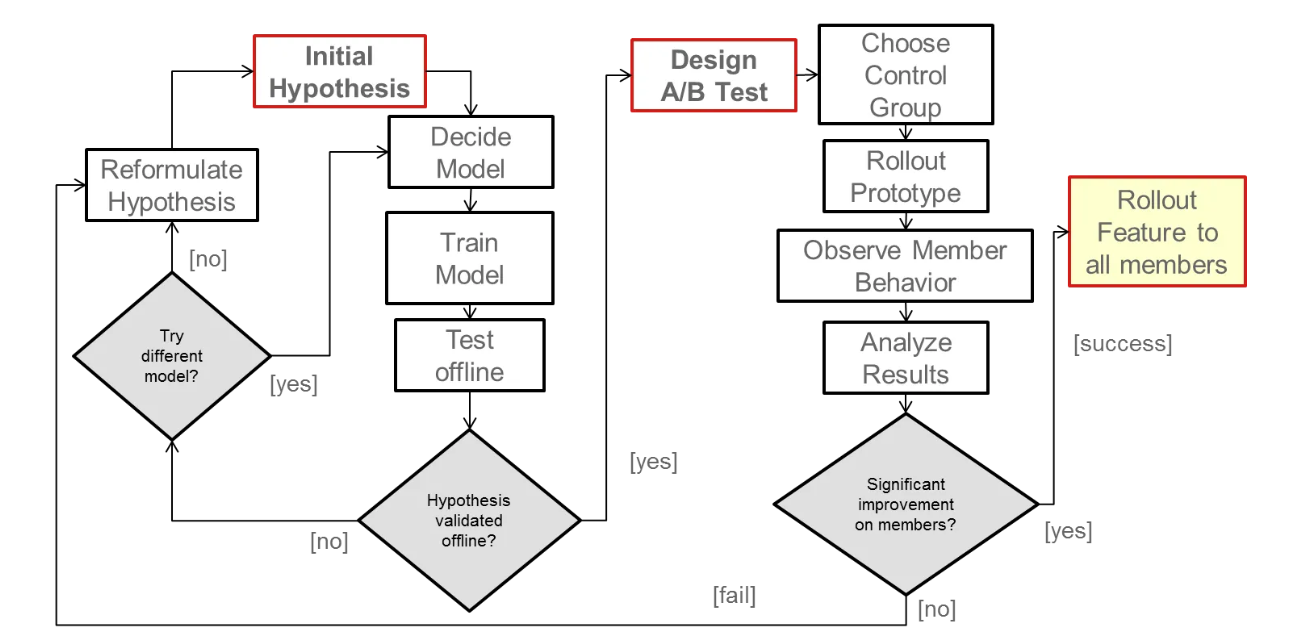

